<a href="https://colab.research.google.com/github/RobbieEarle/al_da/blob/master/testing_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

import json
from google.colab import drive
from datetime import datetime
from pytz import timezone    

Loading Dataset

In [2]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
mnist_tr = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_te = datasets.MNIST(root='./data', train=False, download=True, transform=trans)

# Customize batch size, and allows us to take subsets of the test & train data
batch_size = 50
train_subset_size = 8000
test_subset_size = 5000
trimmed_mnist_tr, _ = torch.utils.data.random_split(mnist_tr, [train_subset_size, len(mnist_tr) - train_subset_size])
trimmed_mnist_te, _ = torch.utils.data.random_split(mnist_te, [test_subset_size, len(mnist_te) - test_subset_size])

train_loader = torch.utils.data.DataLoader(
                 dataset=trimmed_mnist_tr,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=trimmed_mnist_te,
                batch_size=batch_size,
                shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8508637.06it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129183.73it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2076210.90it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 49806.61it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Defining simple single layer NN w/ ReLU activation

In [0]:
class ReluNet(nn.Module):

  def __init__(self, n_params=25818, n_inputs=784, n_outputs=10):
    super(ReluNet, self).__init__()

    # Choosing number of hidden nodes to ensure number of parameters is
    # approximately correct. Second hidden layer has half as many nodes as
    # first.
    n_h1 = int(np.sqrt(np.square(n_inputs + (0.5 * n_outputs)) + (2 * n_params))) - 789
    n_h2 = int(n_h1 / 2)
    if n_h1 == 0:
      n_h1 = 1
    if n_h2 == 0:
      n_h2 = 1

    self.fc1 = nn.Linear(n_inputs, n_h1)
    self.fc2 = nn.Linear(n_h1, n_h2)
    self.fc3 = nn.Linear(n_h2, n_outputs)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x

Defining function to train a given model

In [0]:
def train_model(model, verbose=False):

  # Defines optimizer, loss, and default value for global vars
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  curr_highest_acc = 0
  num_times_fail_to_improve = 0
  epoch = 0

  # Output number of parameters being tested by this training session
  num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("----> Total Number of Parameters: " + str(num_params))

  # Start recording time to converge
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  # Algorithm continues running epochs until we have 3 straight epochs with no
  # improvement
  while num_times_fail_to_improve < 3:
    
    # -------- Training
    model.train()
    epoch += 1
    for batch_idx, (x, target) in enumerate(train_loader):
      
      # Training model using minibatch
      optimizer.zero_grad()
      out = model(x)
      train_loss = criterion(out, target)
      train_loss.backward()
      optimizer.step()

      # If verbose, prints out loss updates 5 times per epoch
      if verbose and batch_idx % (int(len(train_loader) / 5)) == 0:
        print (
              'epoch {:>5}, batch element {:>5}, train_loss {:9.3f}'
              .format(epoch, batch_idx, train_loss.item())
          )

      # -------- Testing 
      # Occurs at the end of each epoch
      if batch_idx == len(train_loader) - 1:

        num_correct = 0
        num_total = 0
        model.eval()

        with torch.no_grad():
          for batch_idx2, (x, target) in enumerate(test_loader):
            
            # For each batch in our test set we check how many correct
            # predictions and how many predictions were made
            out = model(x)
            test_loss = criterion(out, target)
            _, prediction = torch.max(out.data, 1)
            num_correct += torch.sum(prediction == target.data)
            num_total += len(prediction)

          # After going through all batches, accuracy is proportion of correct
          # responses
          accuracy = num_correct * 1.0 / num_total

          # Checks if this epoch gave us an improvement in test accuracy
          if accuracy > curr_highest_acc:
            curr_highest_acc = accuracy
            num_times_fail_to_improve = 0
          else:
            num_times_fail_to_improve += 1

          # Outputs test results for this epoch
          print (
              'epoch {:>5}, batch element {:>5}, train_loss {:9.3f}, test_loss {:9.3f}, test accuracy {:.3f}'
              .format(epoch, batch_idx, train_loss.item(), test_loss.item(), accuracy)
          )
  print()

  end.record()
  torch.cuda.synchronize()

  return num_params, float(curr_highest_acc), epoch, start.elapsed_time(end)

Running experiment to examine performance vs number of parameters

In [0]:
# Create JSON object
timestamp = str(datetime.now(timezone('Canada/Atlantic')))
output = {
    "timestamp":timestamp,
    "metadata":{
        "dataset":"MNIST",
        "train_data":train_subset_size,
        "test_data":test_subset_size,
        "batch_size":batch_size,
        "network_type":"feed forward",
        "num_hidden_layers":2,
        "activation":"ReLU"
    },
    "data":[]
}

# Decide how many parameters to increase by in each iteration
num_params_step = 1000
i = 1

# Repeatedly train models with an increasing number of parameters. Make an entry
# for each in our output dict and periodically save
drive.mount('/content/drive')
while True:
  params, acc, epoch, time_mil = train_model(ReluNet(num_params_step * i))
  entry = {
      "num_params":params,
      "accuracy":acc,
      "num_epochs":epoch,
      "train_time":time_mil
  }
  output["data"].append(entry)
  i += 1
  with open('/content/drive/My Drive/combinact_outputs/_CURR_OUTPUT.json', 'w') as outfile:
    json.dump(output, outfile)
drive.flush_and_unmount()

In [0]:
# https://stackoverflow.com/a/16344128

# Load saved data
drive.mount('/content/drive')
with open('/content/drive/My Drive/combinact_outputs/relu_combinact_data_01_24_1.json', 'r') as infile:
  loaded_experiment = json.load(infile)
drive.flush_and_unmount()

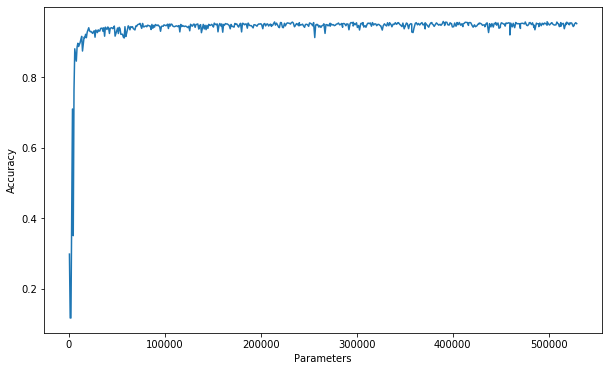

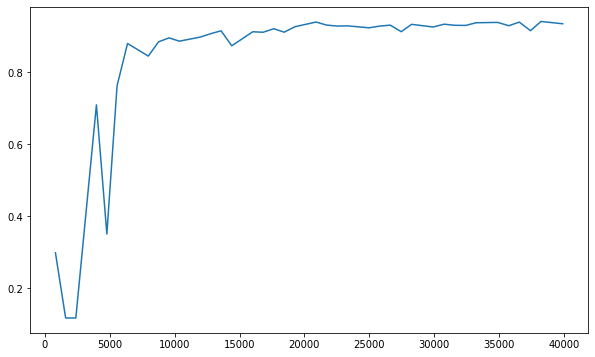

In [21]:
# Plot observations

observations = np.zeros((len(loaded_experiment["data"]), 2))
for i, entry in enumerate(loaded_experiment["data"]):
  observations[i,0] = entry["num_params"]
  observations[i,1] = entry["accuracy"]

plt.figure(figsize=(10,6))
plt.plot(observations[:,0], observations[:,1])
plt.xlabel('Parameters')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(observations[:40,0], observations[:40,1])
plt.show()